In [ ]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("Todas as bibliotecas importadas com sucesso!")

In [ ]:
def carregar_csv_do_zip_remoto(url_zip, nome_csv=None, cache_local=True):
    """
    Carrega um arquivo CSV de um ZIP remoto
    
    Parâmetros:
    -----------
    url_zip : str
        URL do arquivo ZIP
    nome_csv : str, optional
        Nome do arquivo CSV dentro do ZIP
    cache_local : bool, default=True
        Se True, salva o CSV localmente
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame com os dados carregados
    """
    
    print("=" * 80)
    print("CARREGANDO DADOS DE FORMA REMOTA")
    print("=" * 80)
    
    # Verificar se arquivo local existe
    if cache_local and nome_csv and os.path.exists(nome_csv):
        print(f"\n✓ Arquivo local encontrado: {nome_csv}")
        print("  Carregando do cache local...")
        try:
            df = pd.read_csv(nome_csv, delimiter=';', low_memory=False, encoding='latin1')
            print(f"Dataset carregado com sucesso!")
            print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
            return df
        except Exception as e:
            print(f"Erro ao carregar arquivo local: {e}")
            print("Tentando baixar novamente...")
    
    # Baixar ZIP remoto
    print(f"\nBaixando arquivo ZIP remoto...")
    print(f"   URL: {url_zip}")
    
    try:
        response = requests.get(url_zip, timeout=300)
        response.raise_for_status()
        print(f"Download concluído ({len(response.content) / (1024**2):.2f} MB)")
    except Exception as e:
        print(f"Erro ao baixar: {e}")
        raise
    
    # Extrair ZIP
    print(f"\nExtraindo arquivo ZIP...")
    try:
        zip_file = zipfile.ZipFile(io.BytesIO(response.content))
        print(f"Arquivos no ZIP: {zip_file.namelist()}")
    except Exception as e:
        print(f" Erro ao extrair ZIP: {e}")
        raise
    
    # Encontrar arquivo CSV
    if nome_csv is None:
        csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
        if not csv_files:
            raise ValueError("Nenhum arquivo CSV encontrado no ZIP")
        nome_csv = csv_files[0]
        print(f"Arquivo CSV encontrado: {nome_csv}")
    
    # Ler CSV do ZIP
    print(f"\nLendo arquivo CSV...")
    try:
        with zip_file.open(nome_csv) as csv_file:
            df = pd.read_csv(csv_file, delimiter=';', low_memory=False, encoding='latin1')
        print(f"✓ Dataset carregado com sucesso!")
        print(f"  Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas")
    except Exception as e:
        print(f"✗ Erro ao ler CSV: {e}")
        raise
    
    # Salvar localmente (cache)
    if cache_local:
        print(f"\nSalvando arquivo localmente para futuras execuções...")
        try:
            df.to_csv(nome_csv, index=False, sep=';', encoding='latin1')
            print(f" Arquivo salvo: {nome_csv}")
        except Exception as e:
            print(f" Aviso: Não foi possível salvar localmente: {e}")
    
    print("\n" + "=" * 80)
    return df

print("Função carregar_csv_do_zip_remoto definida!")

In [ ]:
# URL do arquivo ZIP no DATASUS
url_zip = "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/csv/DO24OPEN_csv.zip"

# Carregar dados
df = carregar_csv_do_zip_remoto(
    url_zip=url_zip,
    nome_csv='DO24OPEN.csv',
    cache_local=True
)

# Exibir informações
print("\n✓ Dados carregados!")
print(f"Shape: {df.shape}")
print(f"\nPrimeiras linhas:")
print(df.head())


# Passo 1: Verificar Cache Local

if cache_local and nome_csv and os.path.exists(nome_csv):
    df = pd.read_csv(nome_csv, delimiter=';', low_memory=False, encoding='latin1')
    return df

# Passo 2: Baixar ZIP Remoto

response = requests.get(url_zip, timeout=300)
response.raise_for_status()

zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Passo 4: Encontrar CSV
csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
nome_csv = csv_files[0]

# Passo 5: Ler CSV
with zip_file.open(nome_csv) as csv_file:
    df = pd.read_csv(csv_file, delimiter=';', low_memory=False, encoding='latin1')

# Passo 6: Salvar Cache Local
df.to_csv(nome_csv, index=False, sep=';', encoding='latin1')

In [23]:
# Configurações iniciais
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [25]:
# ============================================================================
# 1. CARREGAMENTO E EXPLORAÇÃO DOS DADOS
# ============================================================================
print("\n[1] CARREGANDO OS DADOS...")
try:
    df = pd.read_csv('DO24OPEN.csv', delimiter=';', low_memory=False, encoding='latin1')
    print(f"✓ Dataset carregado com sucesso!")
    print(f"  Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas")
except Exception as e:
    print(f"✗ Erro ao carregar: {e}")
    exit()


[1] CARREGANDO OS DADOS...
✓ Dataset carregado com sucesso!
  Dimensões: 1426346 linhas × 86 colunas


In [26]:
print("\nColunas disponíveis:")
print(df.columns.tolist())


Colunas disponíveis:
['contador', 'ORIGEM', 'TIPOBITO', 'DTOBITO', 'HORAOBITO', 'NATURAL', 'CODMUNNATU', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'ESC2010', 'SERIESCFAL', 'OCUP', 'CODMUNRES', 'LOCOCOR', 'CODESTAB', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'ESCMAE2010', 'SERIESCMAE', 'OCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'SEMAGESTAC', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO', 'TPMORTEOCO', 'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA', 'NECROPSIA', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS', 'CB_PRE', 'COMUNSVOIM', 'DTATESTADO', 'CIRCOBITO', 'ACIDTRAB', 'FONTE', 'NUMEROLOTE', 'DTINVESTIG', 'DTCADASTRO', 'ATESTANTE', 'STCODIFICA', 'CODIFICADO', 'VERSAOSIST', 'VERSAOSCB', 'FONTEINV', 'DTRECEBIM', 'ATESTADO', 'DTRECORIGA', 'OPOR_DO', 'CAUSAMAT', 'ESCMAEAGR1', 'ESCFALAGR1', 'STDOEPIDEM', 'STDONOVA', 'DIFDATA', 'NUDIASOBCO', 'DTCADINV', 'TPOBITOCOR', 'DTCONINV', 'FONTES', 'TPRESGINFO', 'TPNIVELINV', 'DTCADINF', 'MORTEPARTO', 'DTCONCASO

In [27]:
print("\nTipos de dados:")
print(df.dtypes)


Tipos de dados:
contador        int64
ORIGEM          int64
TIPOBITO        int64
DTOBITO         int64
HORAOBITO     float64
               ...   
ALTCAUSA      float64
CAUSABAS_O     object
TPPOS          object
TP_ALTERA     float64
CB_ALT         object
Length: 86, dtype: object


In [ ]:
# ============================================================================
# 2. PRÉ-PROCESSAMENTO DOS DADOS
# ============================================================================
print("\nPRÉ-PROCESSAMENTO DOS DADOS...")


[2] PRÉ-PROCESSAMENTO DOS DADOS...


In [29]:
# Seleção de variáveis relevantes para predição
# Variáveis demográficas e características da morte
variaveis_selecionadas = [
    'IDADE_CALCULADA',  # Idade
    'SEXO',              # Sexo (1=Masculino, 2=Feminino)
    'RACACOR',           # Raça/Cor
    'ESC2010',           # Escolaridade
    'LOCOCOR',           # Local de ocorrência
    'CIRCOBITO',         # Circunstância do óbito
    'CAUSABAS'           # Causa básica (alvo)
]

In [30]:
# Verificar quais colunas existem
colunas_existentes = [col for col in variaveis_selecionadas if col in df.columns]
print(f"Variáveis selecionadas: {colunas_existentes}")

Variáveis selecionadas: ['SEXO', 'RACACOR', 'ESC2010', 'LOCOCOR', 'CIRCOBITO', 'CAUSABAS']


In [31]:
# Criar dataset com variáveis selecionadas
df_ml = df[colunas_existentes].copy()

In [32]:
print(f"\nDataset para ML: {df_ml.shape}")
print(f"Valores ausentes:\n{df_ml.isnull().sum()}")


Dataset para ML: (1426346, 6)
Valores ausentes:
SEXO               0
RACACOR        19445
ESC2010        91225
LOCOCOR            0
CIRCOBITO    1283156
CAUSABAS           0
dtype: int64


In [33]:
# Remover linhas com valores ausentes
df_ml = df_ml.dropna()
print(f"Dataset após remover NaN: {df_ml.shape}")

Dataset após remover NaN: (133658, 6)


In [34]:
# ============================================================================
# 3. TRATAMENTO DA VARIÁVEL ALVO
# ============================================================================
print("\n[3] TRATAMENTO DA VARIÁVEL ALVO (CAUSABAS)...")


[3] TRATAMENTO DA VARIÁVEL ALVO (CAUSABAS)...


In [35]:
# Verificar distribuição da causa básica
print(f"\nDistribuição de causas (top 10):")
print(df_ml['CAUSABAS'].value_counts().head(10))


Distribuição de causas (top 10):
CAUSABAS
X954    10423
Y349     8816
X700     7202
X959     4234
W189     3913
V892     3058
W180     2952
V299     2728
X950     2392
Y299     2334
Name: count, dtype: int64


In [36]:
# Agrupar causas menos frequentes em "Outras"
# Manter apenas as 10 principais causas
top_causas = df_ml['CAUSABAS'].value_counts().head(10).index
df_ml['CAUSABAS_AGRUPADA'] = df_ml['CAUSABAS'].apply(
    lambda x: x if x in top_causas else 'Outras'
)

In [37]:
print(f"\nDistribuição após agrupamento:")
print(df_ml['CAUSABAS_AGRUPADA'].value_counts())


Distribuição após agrupamento:
CAUSABAS_AGRUPADA
Outras    85606
X954      10423
Y349       8816
X700       7202
X959       4234
W189       3913
V892       3058
W180       2952
V299       2728
X950       2392
Y299       2334
Name: count, dtype: int64


In [38]:
# ============================================================================
# 4. CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS
# ============================================================================
print("\n[4] CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS...")


[4] CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS...


In [39]:
# Separar variáveis numéricas e categóricas
X = df_ml.drop(['CAUSABAS', 'CAUSABAS_AGRUPADA'], axis=1)
y = df_ml['CAUSABAS_AGRUPADA']

In [40]:
# Dicionário para armazenar encoders
label_encoders = {}

In [41]:
# Codificar variáveis categóricas
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"  ✓ {col} codificado")

In [42]:
# Codificar variável alvo
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

In [43]:
print(f"\nVariáveis de entrada (X): {X.shape}")
print(f"Variável alvo (y): {y_encoded.shape}")
print(f"Classes: {le_target.classes_}")


Variáveis de entrada (X): (133658, 5)
Variável alvo (y): (133658,)
Classes: ['Outras' 'V299' 'V892' 'W180' 'W189' 'X700' 'X950' 'X954' 'X959' 'Y299'
 'Y349']


In [44]:
# ============================================================================
# 5. DIVISÃO DOS DADOS EM TREINO E TESTE
# ============================================================================
print("\n[5] DIVISÃO DOS DADOS...")


[5] DIVISÃO DOS DADOS...


In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [46]:
print(f"Conjunto de treino: {X_train.shape}")
print(f"Conjunto de teste: {X_test.shape}")
print(f"\nDistribuição no treino:\n{pd.Series(y_train).value_counts()}")
print(f"\nDistribuição no teste:\n{pd.Series(y_test).value_counts()}")

Conjunto de treino: (106926, 5)
Conjunto de teste: (26732, 5)

Distribuição no treino:
0     68485
7      8338
10     7053
5      5762
8      3387
4      3130
2      2446
3      2362
1      2182
6      1914
9      1867
Name: count, dtype: int64

Distribuição no teste:
0     17121
7      2085
10     1763
5      1440
8       847
4       783
2       612
3       590
1       546
6       478
9       467
Name: count, dtype: int64


In [47]:
# ============================================================================
# 6. BALANCEAMENTO DE CLASSES COM SMOTE
# ============================================================================
print("\n[6] BALANCEAMENTO DE CLASSES COM SMOTE...")


[6] BALANCEAMENTO DE CLASSES COM SMOTE...


In [48]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [49]:
print(f"Treino após SMOTE: {X_train_balanced.shape}")
print(f"Distribuição após SMOTE:\n{pd.Series(y_train_balanced).value_counts()}")

Treino após SMOTE: (753335, 5)
Distribuição após SMOTE:
0     68485
7     68485
9     68485
8     68485
10    68485
2     68485
5     68485
6     68485
4     68485
1     68485
3     68485
Name: count, dtype: int64


In [50]:
# ============================================================================
# 7. NORMALIZAÇÃO DOS DADOS
# ============================================================================
print("\n[7] NORMALIZAÇÃO DOS DADOS...")


[7] NORMALIZAÇÃO DOS DADOS...


In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [52]:
print("✓ Dados normalizados com StandardScaler")

✓ Dados normalizados com StandardScaler


In [53]:
# ============================================================================
# 8. TÉCNICA 1: REGRESSÃO LOGÍSTICA
# ============================================================================
print("\n" + "=" * 80)
print("TÉCNICA 1: REGRESSÃO LOGÍSTICA")
print("=" * 80)


TÉCNICA 1: REGRESSÃO LOGÍSTICA


In [54]:
print("\nTreinando modelo de Regressão Logística...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train_scaled, y_train_balanced)


Treinando modelo de Regressão Logística...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [55]:
# Predições
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)

In [56]:
# Avaliação
print("\nRESULTADOS - REGRESSÃO LOGÍSTICA:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precisão (média): {precision_score(y_test, y_pred_lr, average='weighted', zero_division=0):.4f}")
print(f"Recall (média): {recall_score(y_test, y_pred_lr, average='weighted', zero_division=0):.4f}")
print(f"F1-Score (média): {f1_score(y_test, y_pred_lr, average='weighted', zero_division=0):.4f}")


RESULTADOS - REGRESSÃO LOGÍSTICA:
Acurácia: 0.1803
Precisão (média): 0.4410
Recall (média): 0.1803
F1-Score (média): 0.1396


In [57]:
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_lr, target_names=le_target.classes_, zero_division=0))


Relatório de Classificação:
              precision    recall  f1-score   support

      Outras       0.57      0.04      0.07     17121
        V299       0.07      0.58      0.12       546
        V892       0.06      0.21      0.09       612
        W180       0.10      0.59      0.17       590
        W189       0.04      0.09      0.06       783
        X700       0.33      0.51      0.40      1440
        X950       0.30      0.04      0.06       478
        X954       0.34      0.64      0.44      2085
        X959       0.12      0.31      0.18       847
        Y299       0.12      0.49      0.19       467
        Y349       0.24      0.43      0.30      1763

    accuracy                           0.18     26732
   macro avg       0.21      0.36      0.19     26732
weighted avg       0.44      0.18      0.14     26732



In [58]:
print("\nMatriz de Confusão:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)


Matriz de Confusão:
[[ 619 3863 1979 2479 1052 1140   33 2069  897  825 2165]
 [   0  314   94   92   18    9    0    1    0   11    7]
 [   0  313  127  108   13   28    0    0    0   13   10]
 [   0   93   30  348   51   27    0    0    0   19   22]
 [   0  118   26  420   69    6    0    1    0   60   83]
 [ 120    4    2    1   35  736    0   57  471    0   14]
 [ 130    0    1    1   19   22   17   49  221    1   17]
 [ 136   13    1    1   79  257    3 1338  235    2   20]
 [  62    9    1    1  112   26    3  340  265    9   19]
 [   0   32   18   12   20    4    1   16   22  227  115]
 [  22   30    9   41   67    5    0   87   26  716  760]]


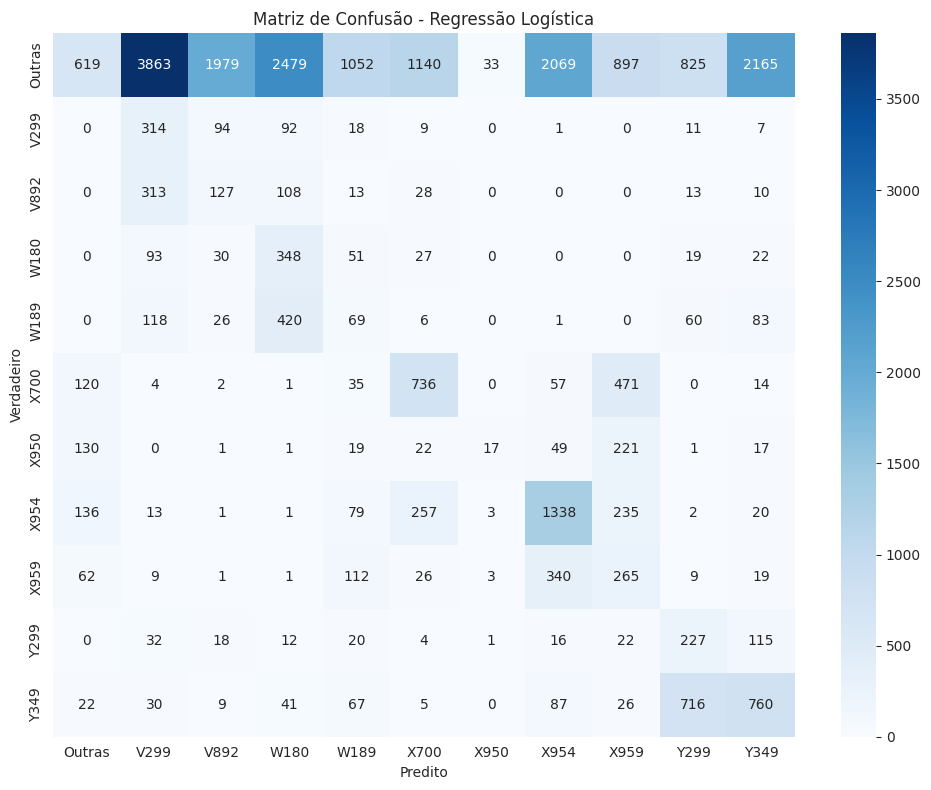

In [59]:
# Visualizar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Matriz de Confusão - Regressão Logística')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.tight_layout()
plt.savefig('matriz_confusao_lr.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
# ============================================================================
# 9. TÉCNICA 2: RANDOM FOREST
# ============================================================================
print("\n" + "=" * 80)
print("TÉCNICA 2: RANDOM FOREST")
print("=" * 80)


TÉCNICA 2: RANDOM FOREST


In [61]:
print("\nTreinando modelo de Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)


Treinando modelo de Random Forest...


,n_estimators,100
,criterion,'gini'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [62]:
# Predições
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

In [63]:
# Avaliação
print("\nRESULTADOS - RANDOM FOREST:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precisão (média): {precision_score(y_test, y_pred_rf, average='weighted', zero_division=0):.4f}")
print(f"Recall (média): {recall_score(y_test, y_pred_rf, average='weighted', zero_division=0):.4f}")
print(f"F1-Score (média): {f1_score(y_test, y_pred_rf, average='weighted', zero_division=0):.4f}")


RESULTADOS - RANDOM FOREST:
Acurácia: 0.1226
Precisão (média): 0.3898
Recall (média): 0.1226
F1-Score (média): 0.1664


In [64]:
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf, target_names=le_target.classes_, zero_division=0))


Relatório de Classificação:
              precision    recall  f1-score   support

      Outras       0.60      0.16      0.26     17121
        V299       0.00      0.00      0.00       546
        V892       0.04      0.00      0.01       612
        W180       0.03      0.70      0.06       590
        W189       0.00      0.00      0.00       783
        X700       0.00      0.00      0.00      1440
        X950       0.00      0.00      0.00       478
        X954       0.00      0.00      0.00      2085
        X959       0.03      0.06      0.04       847
        Y299       0.01      0.06      0.01       467
        Y349       0.09      0.00      0.00      1763

    accuracy                           0.12     26732
   macro avg       0.07      0.09      0.03     26732
weighted avg       0.39      0.12      0.17     26732



In [65]:
print("\nMatriz de Confusão:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)


Matriz de Confusão:
[[2779    2   35 8525  675  296    3    4 1184 3612    6]
 [  17    0    3  248    9    1    0    0   55  213    0]
 [  21    0    2  285   10    1    0    0   53  239    1]
 [  37    0    0  412    0    2    0    0   31  107    1]
 [ 120    0    0  482    2   18    0    0   40  121    0]
 [  12    0   12  755   26    1    0    0  148  484    2]
 [  18    0    2  308    8    2    0    0   40  100    0]
 [  24    0    1 1334   39    0    0    0  157  530    0]
 [  37    1    1  555   43    1    0    3   51  155    0]
 [ 303    0    0   69    5   27    0    0   34   29    0]
 [1302    0    0  153    7  137    0    0  110   53    1]]


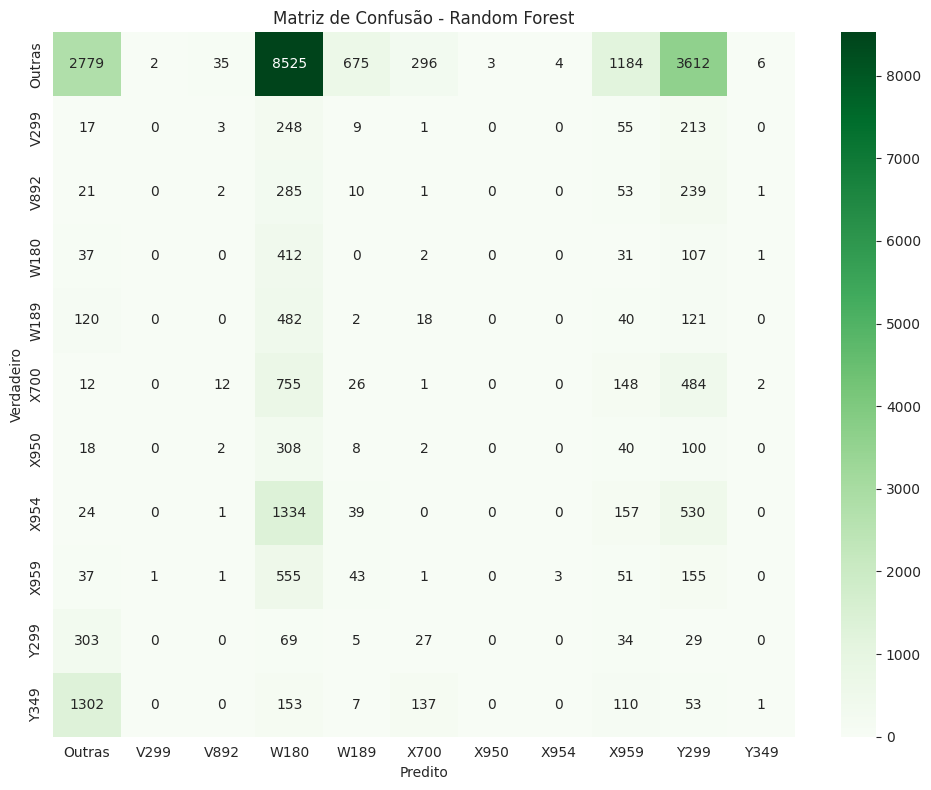

In [66]:
# Visualizar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Matriz de Confusão - Random Forest')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.tight_layout()
plt.savefig('matriz_confusao_rf.png', dpi=300, bbox_inches='tight')
plt.show()

In [67]:
# Importância das features
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

In [68]:
print("\nImportância das Features (Random Forest):")
print(feature_importance_rf)


Importância das Features (Random Forest):
     feature  importance
4  CIRCOBITO    0.563275
3    LOCOCOR    0.309649
2    ESC2010    0.055320
1    RACACOR    0.038484
0       SEXO    0.033272


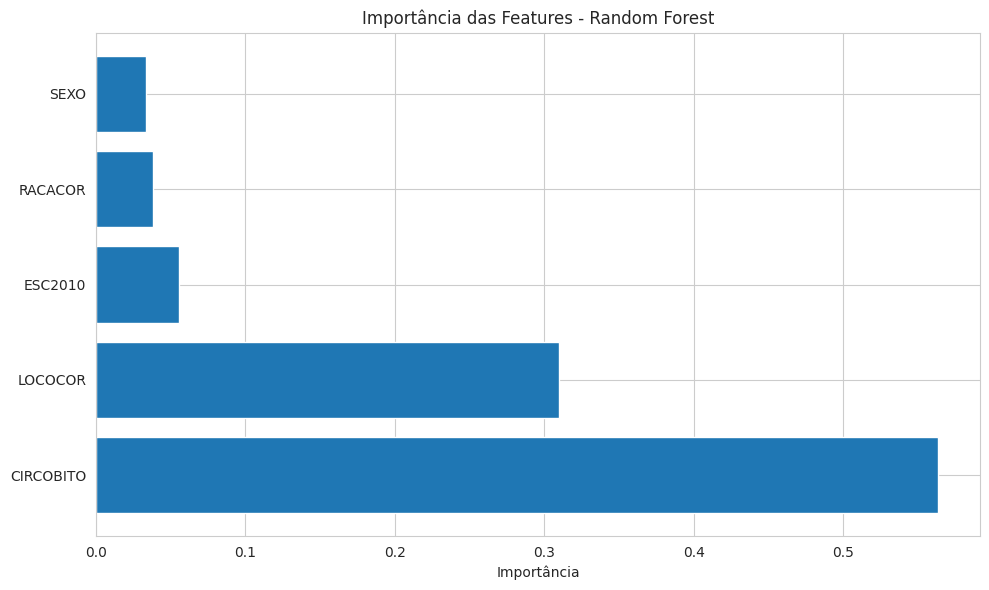

In [69]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['feature'], feature_importance_rf['importance'])
plt.xlabel('Importância')
plt.title('Importância das Features - Random Forest')
plt.tight_layout()
plt.savefig('importancia_features_rf.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
# ============================================================================
# 10. TÉCNICA 3: XGBOOST
# ============================================================================
print("\n" + "=" * 80)
print("TÉCNICA 3: XGBOOST")
print("=" * 80)


TÉCNICA 3: XGBOOST


In [71]:
print("\nTreinando modelo de XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train_balanced, y_train_balanced)


Treinando modelo de XGBoost...


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [92]:
# Predições
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)

In [93]:
# Avaliação
print("\nRESULTADOS - XGBOOST:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precisão (média): {precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0):.4f}")
print(f"Recall (média): {recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0):.4f}")
print(f"F1-Score (média): {f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0):.4f}")


RESULTADOS - XGBOOST:
Acurácia: 0.0233
Precisão (média): 0.3923
Recall (média): 0.0233
F1-Score (média): 0.0040


In [94]:
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_xgb, target_names=le_target.classes_, zero_division=0))


Relatório de Classificação:
              precision    recall  f1-score   support

      Outras       0.61      0.00      0.00     17121
        V299       0.00      0.00      0.00       546
        V892       0.04      0.01      0.01       612
        W180       0.02      0.84      0.04       590
        W189       0.00      0.00      0.00       783
        X700       0.00      0.00      0.00      1440
        X950       0.00      0.00      0.00       478
        X954       0.00      0.00      0.00      2085
        X959       0.02      0.09      0.04       847
        Y299       0.02      0.07      0.03       467
        Y349       0.00      0.00      0.00      1763

    accuracy                           0.02     26732
   macro avg       0.06      0.09      0.01     26732
weighted avg       0.39      0.02      0.00     26732



In [75]:
print("\nMatriz de Confusão:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)


Matriz de Confusão:
[[   14     0    80 13866     0     0     0     1  1962  1198     0]
 [    0     0     2   438     0     0     0     1    64    41     0]
 [    0     0     4   489     0     0     0     0    67    52     0]
 [    0     0     1   496     0     0     0     0    64    29     0]
 [    1     0     0   627     0     0     0     0   109    46     0]
 [    0     0    15  1111     0     0     0     0   191   123     0]
 [    1     0     2   413     0     0     0     0    52    10     0]
 [    0     0     2  1837     0     0     0     0   196    50     0]
 [    7     0     4   740     0     0     0     0    74    22     0]
 [    0     0     0   384     0     0     0     0    48    35     0]
 [    0     0     2  1441     0     0     0     0   184   136     0]]


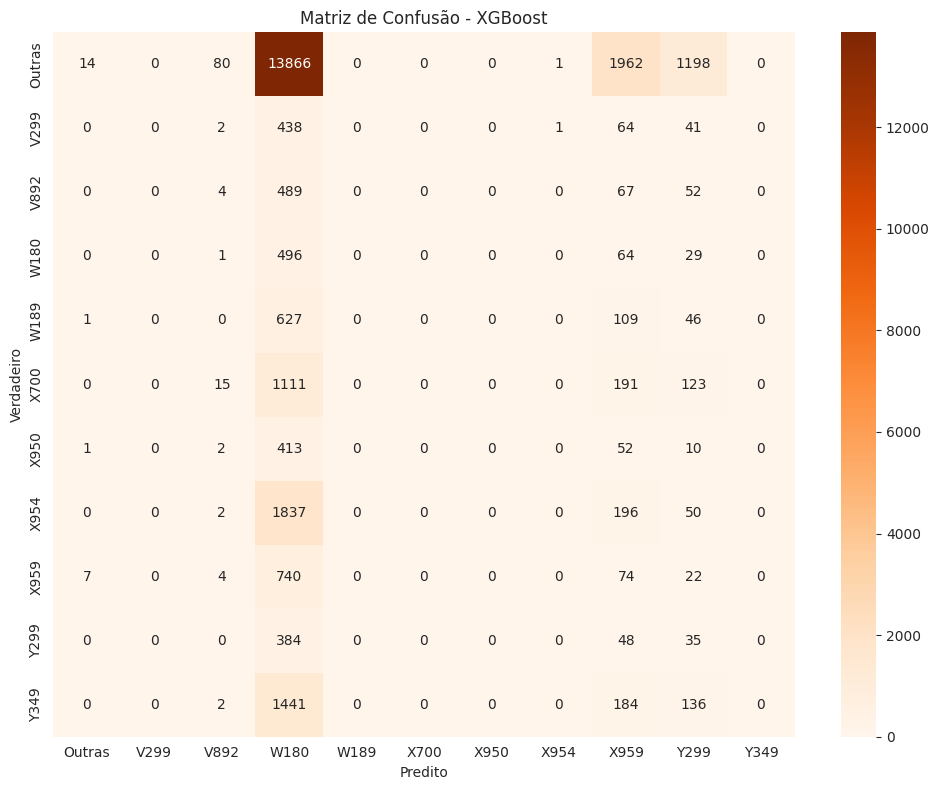

In [95]:
# Visualizar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Matriz de Confusão - XGBoost')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.tight_layout()
plt.savefig('matriz_confusao_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

In [96]:
# Importância das features
feature_importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

In [97]:
print("\nImportância das Features (XGBoost):")
print(feature_importance_xgb)


Importância das Features (XGBoost):
     feature  importance
4  CIRCOBITO    0.796421
3    LOCOCOR    0.145623
0       SEXO    0.034595
2    ESC2010    0.011753
1    RACACOR    0.011609


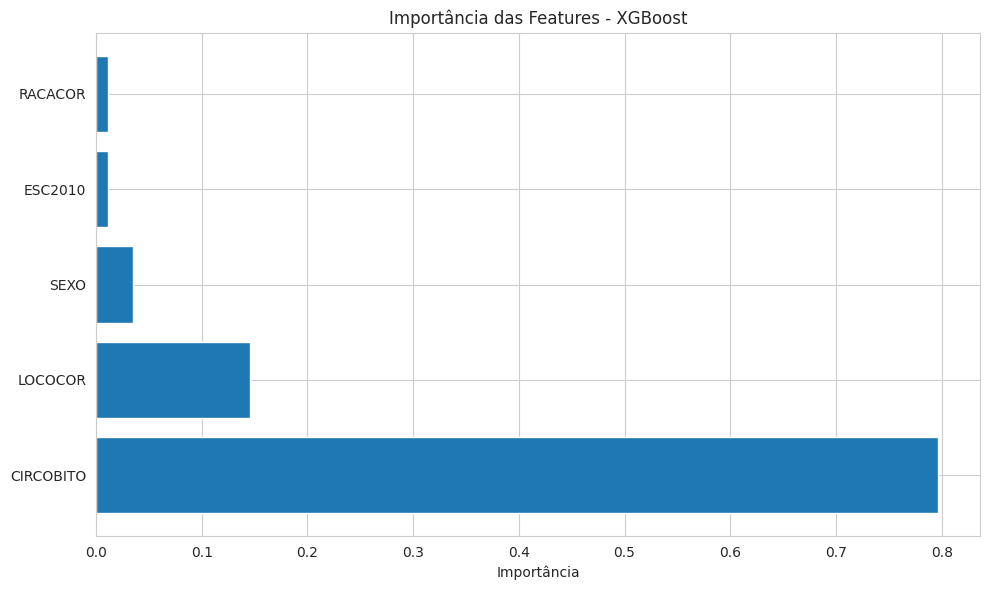

In [98]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb['feature'], feature_importance_xgb['importance'])
plt.xlabel('Importância')
plt.title('Importância das Features - XGBoost')
plt.tight_layout()
plt.savefig('importancia_features_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

In [80]:
# ============================================================================
# 11. COMPARAÇÃO DOS MODELOS
# ============================================================================
print("\n" + "=" * 80)
print("COMPARAÇÃO DOS MODELOS")
print("=" * 80)


COMPARAÇÃO DOS MODELOS


In [81]:
# Criar tabela de comparação
comparacao = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest', 'XGBoost'],
    'Acurácia': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precisão': [
        precision_score(y_test, y_pred_lr, average='weighted', zero_division=0),
        precision_score(y_test, y_pred_rf, average='weighted', zero_division=0),
        precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='weighted', zero_division=0),
        recall_score(y_test, y_pred_rf, average='weighted', zero_division=0),
        recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr, average='weighted', zero_division=0),
        f1_score(y_test, y_pred_rf, average='weighted', zero_division=0),
        f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
    ]
})

In [82]:
print("\n" + comparacao.to_string(index=False))


             Modelo  Acurácia  Precisão   Recall  F1-Score
Regressão Logística  0.180308  0.440954 0.180308  0.139625
      Random Forest  0.122587  0.389753 0.122587  0.166365
            XGBoost  0.023305  0.392299 0.023305  0.004044


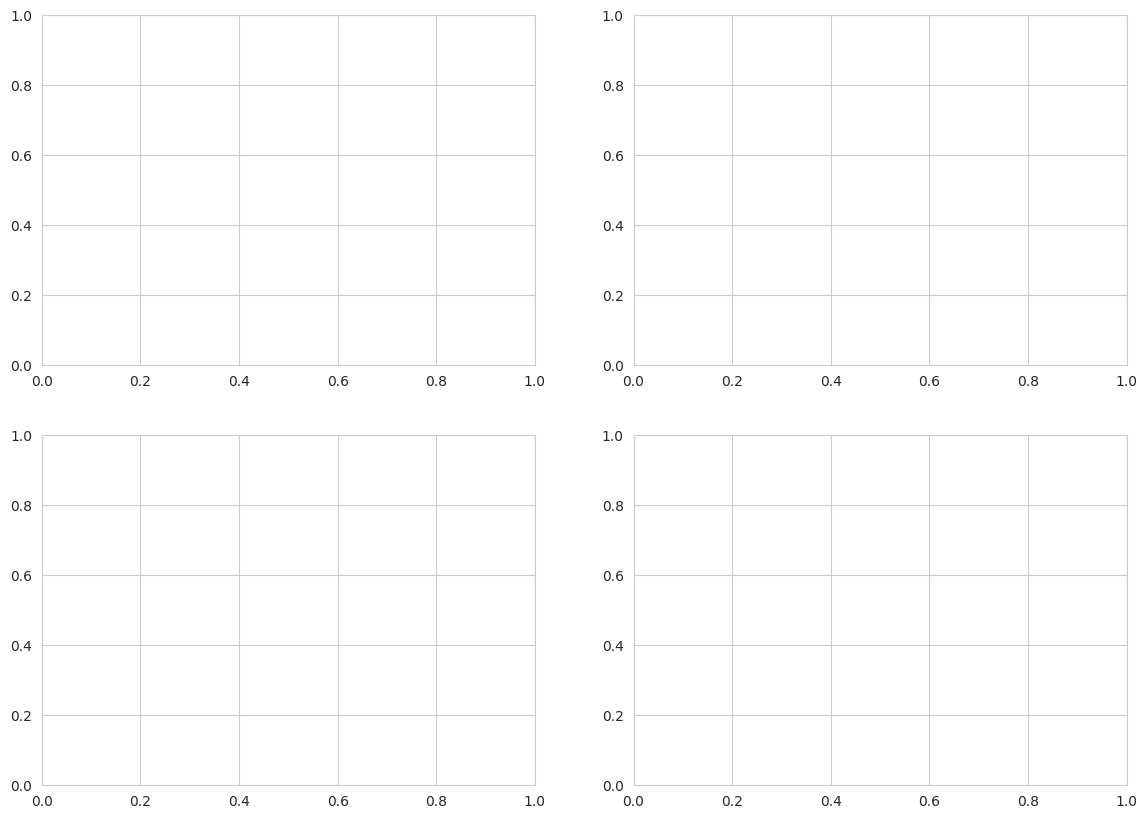

In [99]:
# Visualizar comparação
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

In [100]:
metricas = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
for idx, metrica in enumerate(metricas):
    ax = axes[idx // 2, idx % 2]
    valores = comparacao[metrica].values
    modelos = comparacao['Modelo'].values
    bars = ax.bar(range(len(modelos)), valores, color=['#1f77b4', '#2ca02c', '#ff7f0e'], edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metrica, fontsize=11, fontweight='bold')
    ax.set_title(f'{metrica} por Modelo', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.set_xticks(range(len(modelos)))
    ax.set_xticklabels(modelos, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, v in enumerate(valores):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

In [101]:
plt.tight_layout()
plt.savefig('comparacao_modelos.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico salvo: comparacao_modelos.png")
plt.show()


✓ Gráfico salvo: comparacao_modelos.png


<Figure size 1200x600 with 0 Axes>

In [102]:
# ============================================================================
# 12. CONCLUSÕES
# ============================================================================
print("\n" + "=" * 80)
print("CONCLUSÕES")
print("=" * 80)


CONCLUSÕES


In [103]:
melhor_modelo_idx = comparacao['F1-Score'].idxmax()
melhor_modelo = comparacao.loc[melhor_modelo_idx, 'Modelo']
melhor_f1 = comparacao.loc[melhor_modelo_idx, 'F1-Score']

In [104]:
print(f"\n✓ Melhor modelo: {melhor_modelo}")
print(f"  F1-Score: {melhor_f1:.4f}")


✓ Melhor modelo: Random Forest
  F1-Score: 0.1664


In [106]:
print("\nResumo das Técnicas Implementadas:")
print("1. Regressão Logística: Modelo linear simples e interpretável")
print("2. Random Forest: Ensemble com múltiplas árvores de decisão")
print("3. XGBoost: Gradient boosting com otimização avançada")


Resumo das Técnicas Implementadas:
1. Regressão Logística: Modelo linear simples e interpretável
2. Random Forest: Ensemble com múltiplas árvores de decisão
3. XGBoost: Gradient boosting com otimização avançada


In [107]:
print("\nMétodos de Avaliação Utilizados:")
print("- Acurácia: Proporção de predições corretas")
print("- Precisão: Proporção de predições positivas corretas")
print("- Recall: Proporção de casos positivos identificados")
print("- F1-Score: Média harmônica entre precisão e recall")
print("- Matriz de Confusão: Visualização de erros de classificação")


Métodos de Avaliação Utilizados:
- Acurácia: Proporção de predições corretas
- Precisão: Proporção de predições positivas corretas
- Recall: Proporção de casos positivos identificados
- F1-Score: Média harmônica entre precisão e recall
- Matriz de Confusão: Visualização de erros de classificação


In [108]:
print("\n" + "=" * 80)
print("ANÁLISE CONCLUÍDA COM SUCESSO!")
print("=" * 80)


ANÁLISE CONCLUÍDA COM SUCESSO!
